AUTHOR: haro_cyber

DATE: 2021/1/10


 DCGANにより、次のデータを使ってポケモンを生成させよ。
 https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##データの準備

In [ ]:
import cv2
import numpy as np
import glob


#ディレクトリ名などは適切に書き換える
files = glob.glob("pokemon_images/*")

#picフォルダの後のアスタリスクがポイント
#ここでfilesにフォルダ内のファイル名が代入される

x_train = np.empty((0,64,64,3),dtype='uint8')
size = (64,64)

for fname in files:    #あとはForで1ファイルずつ実行されていく
    img= cv2.imread(fname)  
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)  #解像度を下げる

    x_train = np.append(x_train,[img],axis=0)

x_train.shape  #画像の枚数と形の確認　　（枚数,縦,横,色）

In [ ]:
# チャネル次元の追加
# x_train = x_train[:,:,:,np.newaxis]　すでにカラー画像

# [-1,1]へスケール
x_train = x_train/127.5 - 1

# axis=2の軸（垂直軸）に沿って左右に画像をひっくり返したものもデータに加えて二倍にする
# Nの方向に加えるので、axis=0方向にconcatenateする
x_train = np.concatenate([x_train, x_train[:,:,::-1,:]], axis=0)

# 並び順をシャッフル
np.random.shuffle(x_train)

print('shape of x_train', x_train.shape)

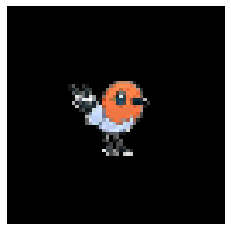

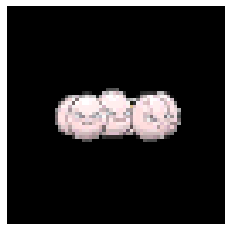

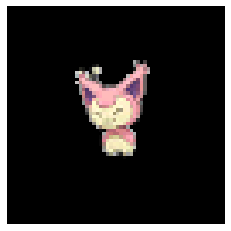

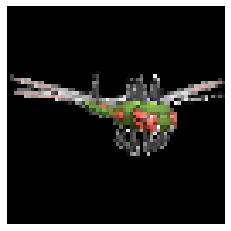

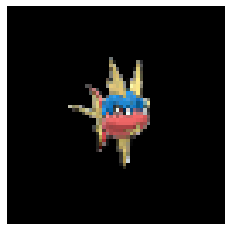

In [14]:
for i in range(5):
    plt.imshow((x_train[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()

##モデルの用意

In [19]:
import tensorflow as tf
from tensorflow import keras

# 使うGPU番号を指定(私の場合は5番を使用)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。（命苫メソッド）
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

RuntimeError: Physical devices cannot be modified after being initialized

In [15]:
latent_dim=100

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

# discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), padding='same', input_shape=(64,64,3)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))
 
# generatorの第一層のサイズ
n_nodes = 512 * 4 * 4
# generator
generator = Sequential()
generator.add(Dense(n_nodes, input_dim=latent_dim))
generator.add(Activation('relu'))
generator.add(Reshape((4, 4, 512)))
generator.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), activation='tanh', padding='same')) #活性化関数はtanh

# コンパイル

opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.trainable = False

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=opt)

In [16]:
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
activation (Activation)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)      

##訓練

In [17]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#datagen = ImageDataGenerator(
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.1,
#    height_shift_range=0.1)

#datagen.fit(x_train)

z_val =  np.random.randn(latent_dim)
z_val = z_val.reshape((1, latent_dim))

d_history = []
g_history = []

def train(x_train, n_epochs=200, n_batch=128):

    bat_per_epoch = int(x_train.shape[0] // n_batch)
    y_real = np.ones((n_batch,))
    y_fake = np.zeros((n_batch,))

    for i in range(n_epochs):
        
        for j in range(bat_per_epoch):

            # Dの訓練をreal、fakeの二段階に分けて実装。この方がうまくいきやすい。
            x_batch = x_train[j*n_batch:(j+1)*n_batch,:]
            ## x_batch_aug = datagen.flow(x_batch, batch_size=n_batch)
            ## x_batch = next(x_batch_aug)
            d_loss_real, _ = discriminator.train_on_batch(x_batch, y_real)

            z =  np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))
            x_fake = generator.predict(z)
            d_loss_fake, _ = discriminator.train_on_batch(x_fake, y_fake)

            # realとfakeのlossの平均値でDのlossを定義
            d_loss = (d_loss_real + d_loss_fake)/2
            d_history.append(d_loss)

            # Gの訓練
            z =  np.random.randn(n_batch*latent_dim)
            z = z.reshape((n_batch, latent_dim))

            g_loss = gan.train_on_batch(z, y_real)
            g_history.append(g_loss)

            if j  == 0:
                print('epoch', i)
                print(d_loss, g_loss)
                x_val = generator.predict(z_val)
                plt.imshow((x_val[0,:,:,:]+1)/2)
                plt.axis("off")
                plt.show()

In [18]:
train(x_train, n_epochs=200, n_batch=128)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-17-d8230c593a9a>:30) ]] [Op:__inference_train_on_batch_1441]

Function call stack:
train_on_batch


##評価

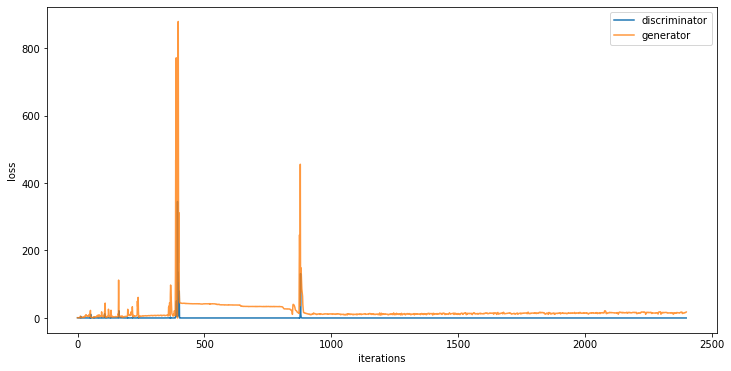

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(d_history, label='discriminator')
plt.plot(g_history, label='generator', alpha=0.8)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


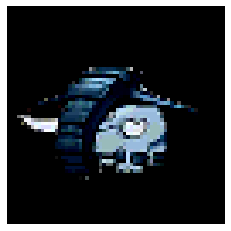

real image


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')


In [ ]:
##フェイク画像の表示を関数化

def make_fake_images():
  # 二つのノイズをサンプリング
  z_1 =  np.random.randn(latent_dim)
  z_2 =  np.random.randn(latent_dim)

  z_1 = z_1.reshape((1, latent_dim))
  z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
  x_1 = generator.predict(z_1)
  x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
  plt.imshow((x_1[0,:,:,:]+1)/2)
  plt.axis("off")
  plt.show()
# フェイク画像２
  plt.imshow((x_2[0,:,:,:]+1)/2)
  plt.axis("off")
  plt.show()

###2nd try

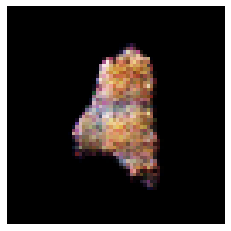

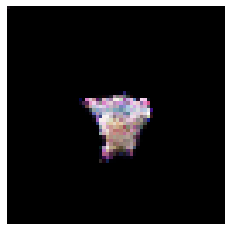

2nd try epoch around 150


In [ ]:
make_fake_images()
print('2nd try epoch around 150')

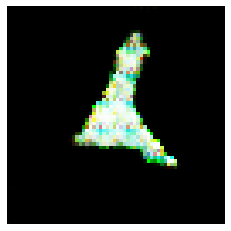

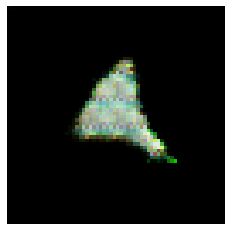

2nd try epoch around 90


In [ ]:
make_fake_images()
print('2nd try epoch around 90')

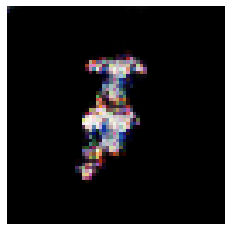

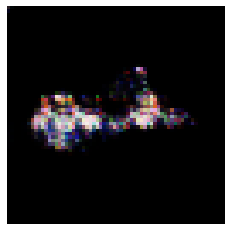

2nd try epoch around 70


In [ ]:
# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('2nd try epoch around 70')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

total_images = 4


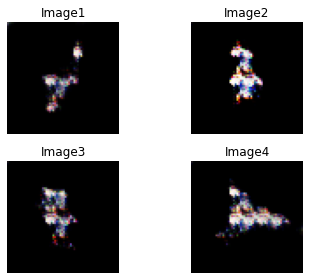

2nd try epoch around 70


In [ ]:


# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)
z_3 =  np.random.randn(latent_dim)
z_4 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))
z_3 = z_3.reshape((1, latent_dim))
z_4 = z_4.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)
x_3 = generator.predict(z_3)
x_4 = generator.predict(z_4)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１〜４

images = {'Image1':(x_1[0,:,:,:]+1)/2,'Image2':(x_2[0,:,:,:]+1)/2,'Image3':(x_3[0,:,:,:]+1)/2,'Image4':(x_4[0,:,:,:]+1)/2}
display_multiple_img(images, rows = 2, cols=2)



print('2nd try epoch around 70')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


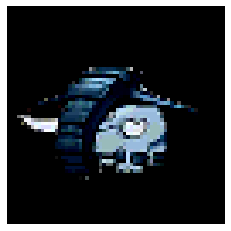

real image


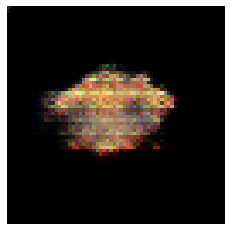

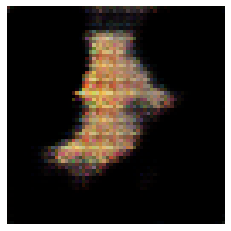

2nd try epoch around 50


In [ ]:


# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('2nd try epoch around 60')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


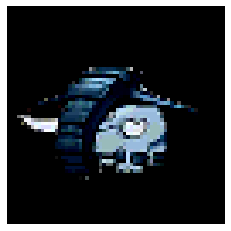

real image


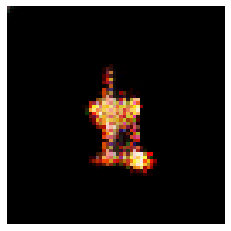

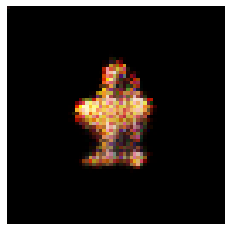

2nd try epoch around 50


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')

# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('2nd try epoch around 50')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


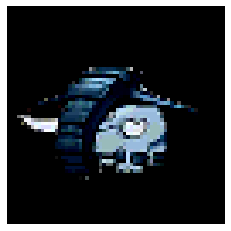

real image


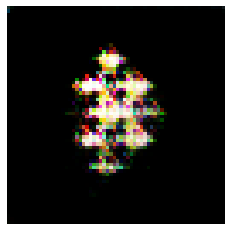

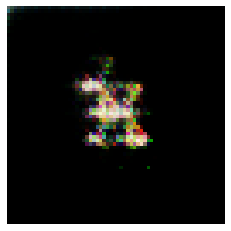

2nd try epoch around 30


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')

# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('2nd try epoch around 30')

###1st try

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


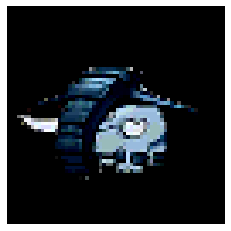

real image


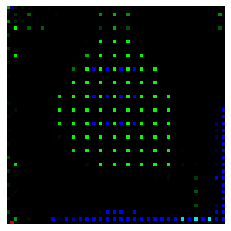

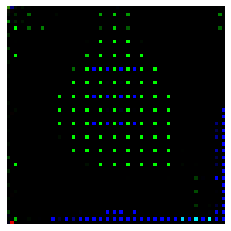

1st try epoch 200


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')

# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('1st try epoch 200')

##ピカチュウ画像
ピカチュウだけを訓練画像にした場合。
（21枚）

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


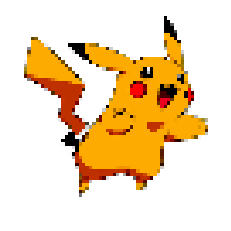

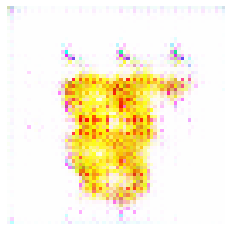

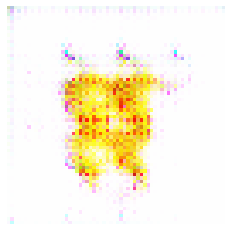

1st try epoch 200


In [ ]:
#リアル画像
plt.imshow(x_train[1])
plt.axis("off")
plt.show()

# 二つのノイズをサンプリング
z_1 =  np.random.randn(latent_dim)
z_2 =  np.random.randn(latent_dim)

z_1 = z_1.reshape((1, latent_dim))
z_2 = z_2.reshape((1, latent_dim))

# これらに対して、Gでフェイク画像を生成
x_1 = generator.predict(z_1)
x_2 = generator.predict(z_2)

# 画素値は[-1,1]にスケールされていたので、[0,1]に戻してプロット
# フェイク画像１
plt.imshow((x_1[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()
# フェイク画像２
plt.imshow((x_2[0,:,:,:]+1)/2)
plt.axis("off")
plt.show()

print('0th try epoch 200')

In [ ]:
import cv2
import numpy as np
import glob


#ディレクトリ名などは適切に書き換える
files = glob.glob("/content/drive/MyDrive/DataFiles/pokemon/pikachu/*")   #GOODフォルダを使用する場合

#picフォルダの後のアスタリスクがポイント
#ここでfilesにフォルダ内のファイル名が代入される

x_train = np.empty((0,64,64,3),dtype='uint8')
size = (64,64)

for fname in files:    #あとはForで1ファイルずつ実行されていく
  img = cv2.imread(fname)  
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, size)  #解像度を下げる

  x_train = np.append(x_train,[img],axis=0)

x_train.shape  #画像の枚数と形の確認　　（枚数,縦,横,色）

(21, 64, 64, 3)

In [ ]:
# チャネル次元の追加
# x_train = x_train[:,:,:,np.newaxis]　すでにカラー画像

# [-1,1]へスケール
x_train = x_train/127.5 - 1

# axis=2の軸（垂直軸）に沿って左右に画像をひっくり返したものもデータに加えて二倍にする
# Nの方向に加えるので、axis=0方向にconcatenateする
x_train = np.concatenate([x_train, x_train[:,:,::-1,:]], axis=0)

# 並び順をシャッフル
np.random.shuffle(x_train)

print('shape of x_train', x_train.shape)

shape of x_train (42, 64, 64, 3)


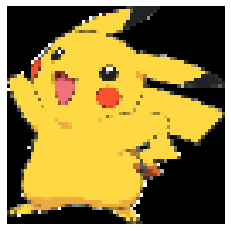

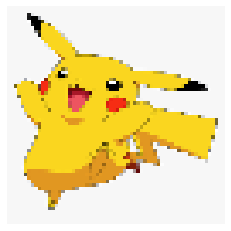

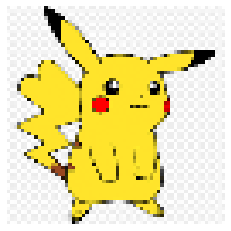

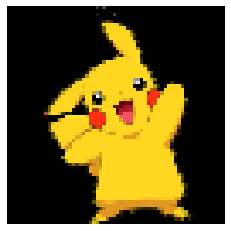

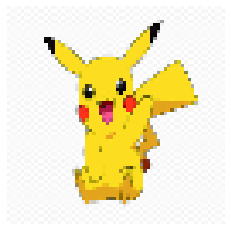

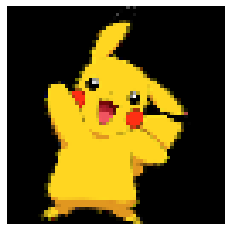

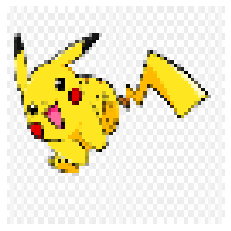

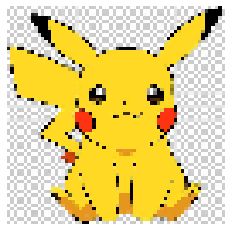

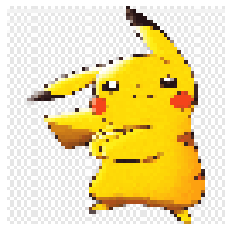

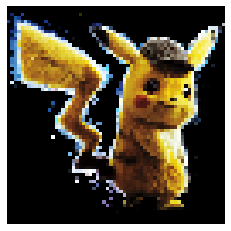

In [ ]:
for i in range(10):
    plt.imshow((x_train[i,:,:,:]+1)/2)
    plt.axis("off")
    plt.show()

In [ ]:
latent_dim=100

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

# discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), padding='same', input_shape=(64,64,3)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))
 
# generatorの第一層のサイズ
n_nodes = 512 * 4 * 4
# generator
generator = Sequential()
generator.add(Dense(n_nodes, input_dim=latent_dim))
generator.add(Activation('relu'))
generator.add(Reshape((4, 4, 512)))
generator.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
generator.add(Activation('relu'))
generator.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), activation='tanh', padding='same')) #活性化関数はtanh

# コンパイル

opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.trainable = False

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
train(x_train, n_epochs=200, n_batch=21)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


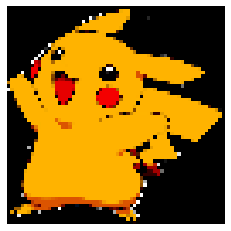

real image


In [ ]:
#リアル画像
plt.imshow(x_train[0])
plt.axis("off")
plt.show()
print('real image')

###2nd try

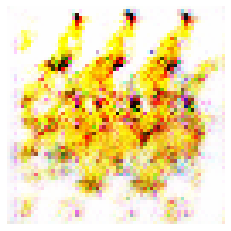

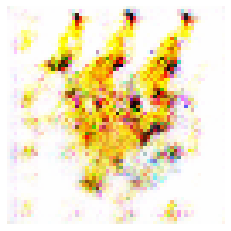

2nd try epoch around 450


In [ ]:
make_fake_images()
print('2nd try epoch around 450')

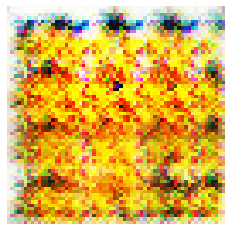

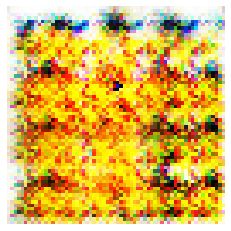

2nd try epoch around 250


In [ ]:
make_fake_images()
print('2nd try epoch around 250')

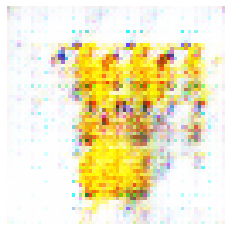

In [ ]:
import cv2

img = cv2.imread("/content/sample_data/Unknown.png")
from google.colab.patches import cv2_imshow
cv2_imshow(img)
print('2nd try epoch around 240')

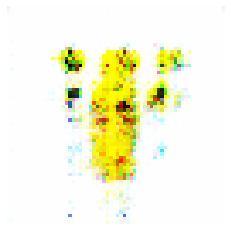

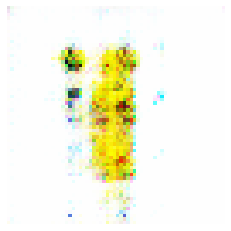

2nd try epoch around 230


In [ ]:
make_fake_images()
print('2nd try epoch around 230')

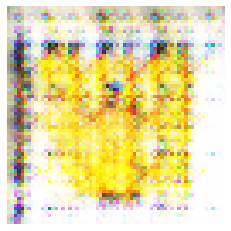

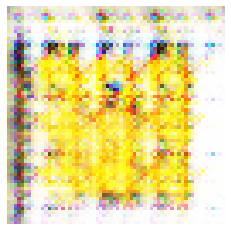

2nd try epoch around 200


In [ ]:
make_fake_images()
print('2nd try epoch around 200')

###1st try

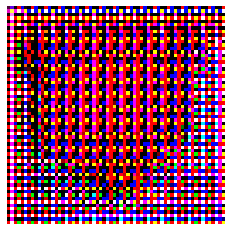

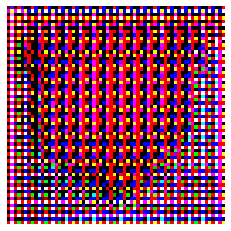

2nd try epoch around 150


In [ ]:
make_fake_images()
print('1st try epoch around 200')

## 考察

800種類以上のポケモンをそれぞれ1枚ずつある訓練データではなかなかそれらしいものが出づらかった。2nd tryの50epoch目の2枚目の画像は第１世代ポケモンのポッポ（ハトに似てるポケモン）に微妙に似ているモザイクのようなフェイク画像ができた。しかし、それ以前、それ以降ではそれらしいものはできなかった。

そしてその後、独自にピカチュウの画像をインターネットから20枚ほど用意し、ピカチュのみでの学習を行なってみた。そうすると3回目(2nd try、実際には１０回くらい試してる)の240epoch目にそれらしいフェイク画像が出てきた。しかし、枚数が少なかったので、すぐに学習を止めようとしたが10epoch通り過ぎて250epochではもう原型がなかった。幸い学習途中の検証画像があったので保存して表示したが、昔のポケモン緑と赤のようなドット絵っぽいフェイク画像ができあがっていた。